# Stargazing Spot Search
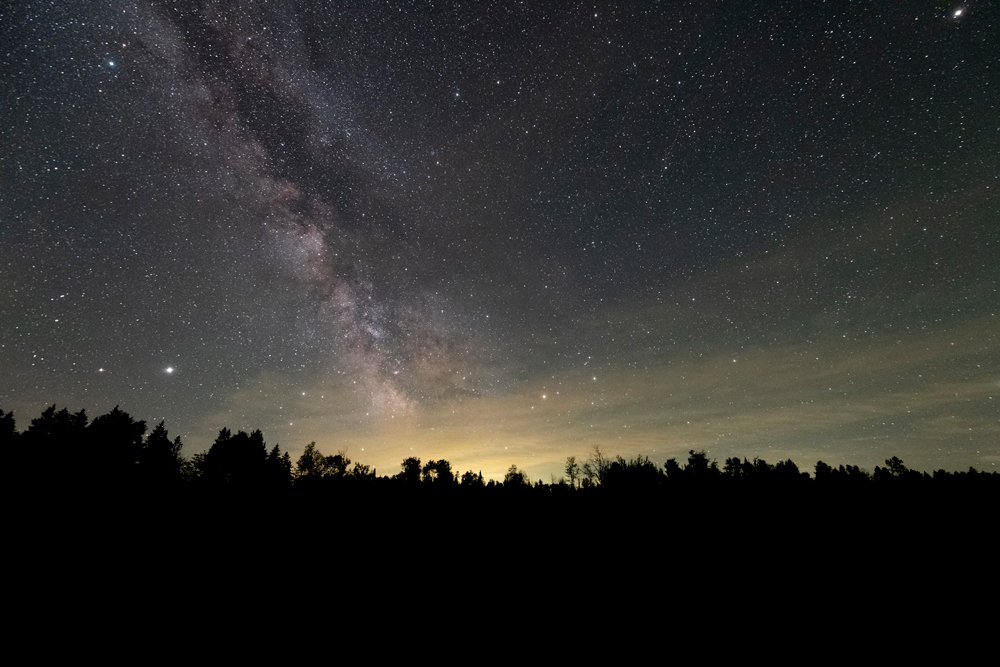
##### Written by: Laure Briol
##### Description: 

This project performs an analysis to search for an ideal night sky viewing locations, based on light pollution, cloud cover, and distance from a start point. The project code uses Google Earth Engine as a cyberinfrastructure to get images for each factor and combine them together. The final result is a map showing where ideal night sky locations are located, with a lighter color indicating bad (bright/not worthwile sky) and darker indicating good (dark, worthwhile views). 

In [1]:
#Earth Engine API installs, so we can use Google Earth Engine in Python
##run this only once if earth engine is not installed
# !pip install earthengine-api

In [2]:
#imports
#Google Earth Engine
import ee
#for Creating Interactive Maps
import folium
#for setting today's date and looking at past dates
from datetime import datetime, timedelta

In [3]:
#set up Google Earth Engine Connection
##BEFORE we do this, we need to SET UP a project in Google Cloud Console
#this is a link for setting up a Google Cloud Console project for Google Earth Engine
# https://developers.google.com/earth-engine/guides/access

#1. Create a project in Google Cloud Console (console.cloud.google.com)
## Project name: stargazinganalysis
#2. Go to APIs & Services --> Enable APIs & Services --> Search Google Earth Engine API --> Enable
#3. Run this chunk of code, it will give us a link, it will ask us to log in, and then authenticate a project, select an existing project, stargazing analysis
#4. Then, we generate a token, and paste it into a text box that will appear below (when run for the first time).

#this sets up login for Google Earth Engine
ee.Authenticate()

#start Google Earth Engine mapping service using our project (service that bills to google cloud project)
ee.Initialize(project='stargazinganalysis')

In [4]:
#user inputs for the project
#user can edit code for whatever location they would like
start_location = [-93.25, 45]
#how much bright lights effect final analysis (weight)
light_multiplier = 1
#how much cloud probability effects final analysis (weight)
cloud_multiplier = 1
#how much the distance from the start point (how far you would have to travel) effects final analysis
distance_multiplier = 1
#in this model light_multiplier, cloud_multipler, and distance_multipler standard weight of 1

In [5]:
#area of interest for our study
##this creates a bounding box that is +/- 1 degree latitude/longitude from our center start point.
aoi = ee.Geometry.Rectangle([start_location[0]-1, start_location[1]-1, start_location[0]+1, start_location[1]+1])

In [6]:
#we want to use the VIIRS light map (light pollution map)
## https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_ANNUAL_V22
light_data = ee.ImageCollection("NOAA/VIIRS/DNB/ANNUAL_V22")

#most recent image from the light pollution map (meaning up-to-date)
light_image = light_data.sort('system:time_start', False).first()

#clip the global image to the area of interest (bounding box)
light_image = light_image.clip(aoi)

#sentinel cloud coverage probability (probabiltiy pixel has cloud within it)
#we average the last ~year of data. This tells us how likely a cloud would be in the sky on any given day
## https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_CLOUD_PROBABILITY
cloud_data = ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY")

#set end date as today's date
end_date = datetime.now().strftime('%Y-%m-%d')
#set start date as one year ago from today
start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')

#getting all sentinel images from last year
cloud_image = cloud_data.filterDate(start_date, end_date)

#average out 1 year of cloud coverage data so it has probability on any given day that a cloud is there
cloud_image = cloud_image.mean().clip(aoi)

In [7]:
#scaling the cloud image from 0-100 to 0-1
cloud_image = cloud_image.unitScale(0, 100)

In [8]:
#creates a point that is located at our start point
start_point = ee.Geometry.Point(start_location)

#creates a raster image where every pixel contains the distance from the start point (measuring distance and then putting distance on map)
distance_image = ee.Image().byte().paint(start_point, 1).fastDistanceTransform(1000, 'pixels', 'squared_euclidean')

#clip the distance image to the area of interest around the bounding box 
distance_image = distance_image.clip(aoi)

#convert the distance image to miles instead of meters
distance_image = distance_image.multiply(0.000621371)

In [9]:
#Now we create a combined image by multiplying the three images together

#select specific bands from light and cloud images if they have multiple bands
light_image = light_image.select('average')
cloud_image = cloud_image.select('probability')

#multiplying each image by the weight (multiplying by the standard 1 weight or the user input)
light_image = light_image.multiply(light_multiplier)
cloud_image = cloud_image.multiply(cloud_multiplier)
distance_image = distance_image.multiply(distance_multiplier)

#create the weighted combination of the two images
combined_image = light_image.multiply(cloud_image)
combined_image = combined_image.multiply(distance_image)

#makes sure we are using the correct band (selects first band)
combined_image = combined_image.select([0])

In [10]:
#create visualization of the light image
##pick which band we want to visualize (average)
##scale 0-100, which is a measure of luminance 
light_params = {
    'bands' : ['average'],
    'min' : 0,
    'max' : 100
}

#Create visualizaiton settings for the cloud image (probability)
#0-1 as the probabibilty is that there is 0% or 100% chance of cloud
cloud_params = {
    'bands' : ['probability'],
    'min' : 0,
    'max' : 1
}

#miles away from start point 
#scale 0 miles away is black and anything greater than 50 miles away is white
distance_params = {
    'min' : 0,
    'max' : 50
}

#define visualization parameters for the combined image
#combined image is a multiplication of all three images together
#we pick a scale that visualizes the data nicely. For default parameters it is 0-10
#using a scale of 0-10, the portion of the value range highlighted has meaningful data differences
#without being overwhelmed by outliers or extreme values.
#palette is color and opacity makes it 'glow'
combined_params = {
    'min': 0,
    'max': 10,  #Adjust this based on data range
    'palette': ['black', 'pink'],
    'opacity': 0.75
}

#create a Folium map centered around bounding box
map_center = [start_location[1], start_location[0]]  #Latitude and longitude of the start point
my_map = folium.Map(location=map_center, zoom_start=8)

In [11]:
#function converts google earth engine image to a folium layer (tile layer)
def add_ee_layer(self, ee_image_object, vis_params, name, show=False):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True,
        show=show
    ).add_to(self)

#add EE drawing method to Folium (make function accessible by folium)
folium.Map.add_ee_layer = add_ee_layer

#add the light layer to the map (turned off to start-- under layers icon)
my_map.add_ee_layer(light_image, light_params, 'Light Map', show=False)

#add the Cloud Probability layer to map (turned off to start-- under layers icon)
my_map.add_ee_layer(cloud_image, cloud_params, 'Cloud Probability', show=False)

#add the Distance from start layer (turned off to start-- under layers icon)
my_map.add_ee_layer(distance_image, distance_params, 'Distance from start', show=False)

#add the combined image to the map (turned on to start-- under layers icon)
my_map.add_ee_layer(combined_image, combined_params, 'Combined Cost', show=True)

#add a circular marker at the start point (for user visualization)
folium.CircleMarker(
    location=map_center,
    radius=4,  
    color='pink',
    fill=True,
    fill_color='pink',
    fill_opacity=0.6,
    popup="Start Point"
).add_to(my_map)

#add layer control to toggle the layers on and off in folium
my_map.add_child(folium.LayerControl())

#display the map
my_map